In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 20)

In [6]:
df = pd.read_csv("../data/clean/clean_data.csv")

## General Price Distribution of our Dataset

To get a better understanding of our dataset let's first visualise how `price` is distributed.


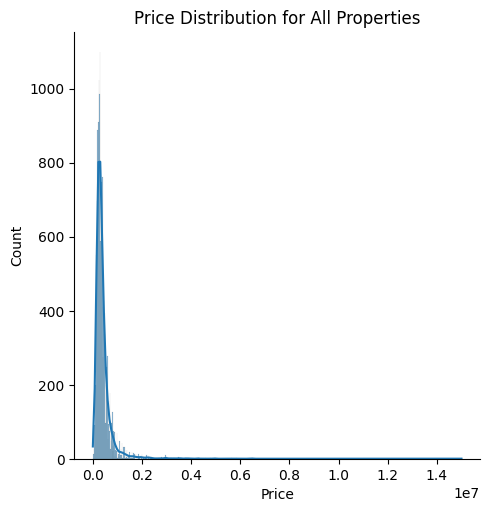

In [7]:
sns.displot(df['price'], binwidth=20000, kde=True)

plt.title('Price Distribution for All Properties')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

We can see that the dataset is highly skewed to the right as it contains outliers with very high prices.

We should remove them using the 1.5 IQR (interquartile range) as it is effective for dealing with skewed distributions.

In [8]:

IQR = df['price'].quantile(0.75) - df['price'].quantile(0.25)

upper_limit = df['price'].quantile(0.75) + 1.5 * IQR
lower_limit = df['price'].quantile(0.25) - 1.5 * IQR

no_outlier_df = df[(df['price'] < upper_limit) & (df['price'] > lower_limit)]



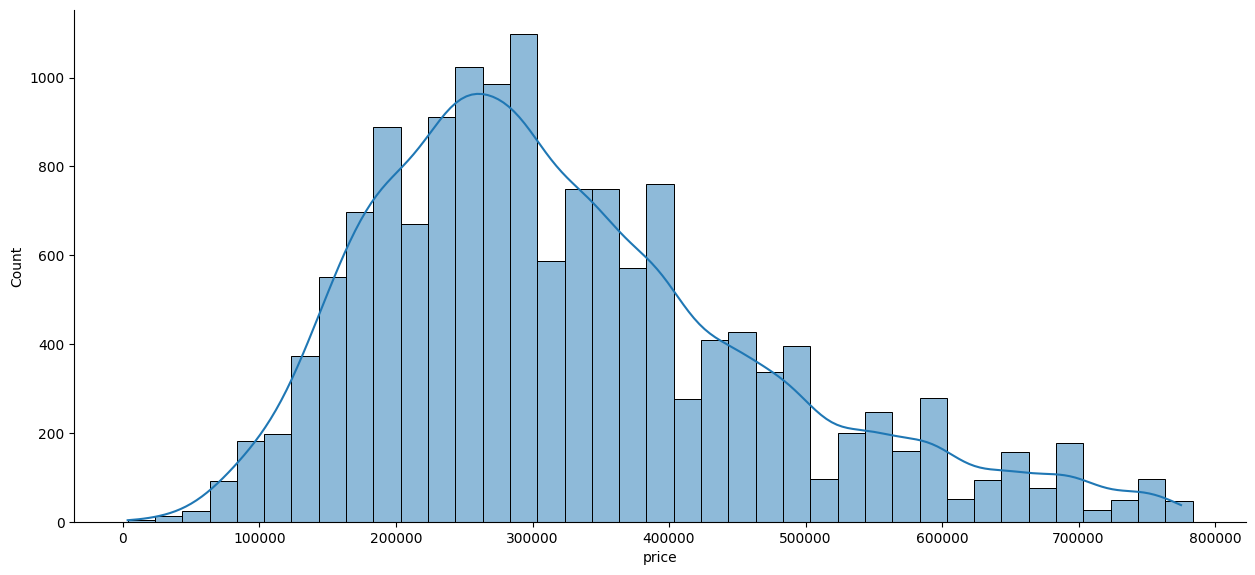

In [9]:
no_outlier_distplot = sns.displot(no_outlier_df['price'], binwidth=20000, kde=True)
no_outlier_distplot.fig.set_size_inches(15,6)
plt.show()

After removing outliers, we observe a much more uniform distribution.

## Price Distribution by Region and Property Type

Now let's visualise this distribution for each `region` and split by property `type` to compare them using a violinplot.

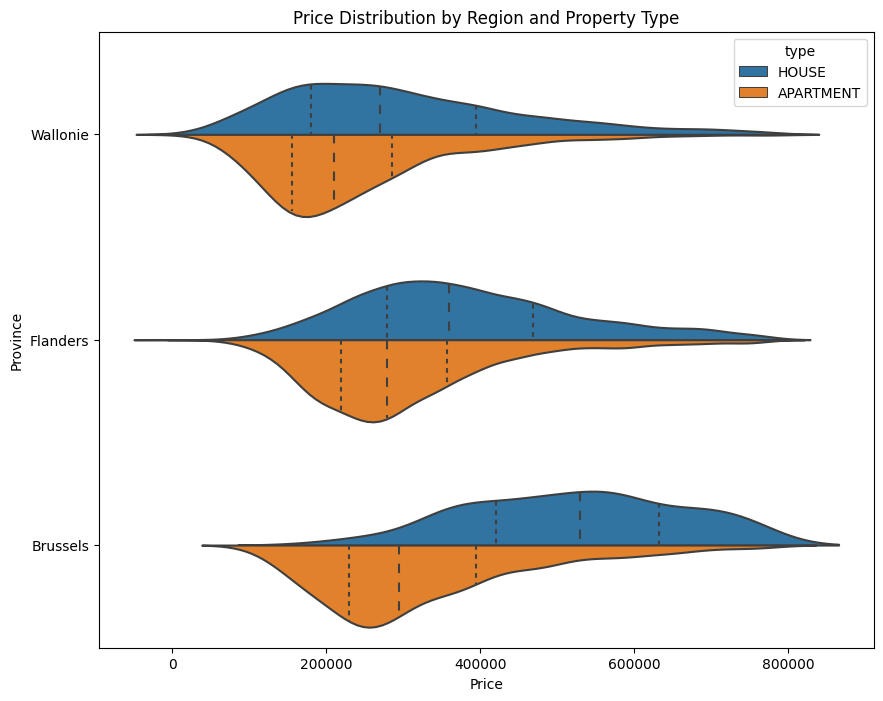

In [10]:
order = sorted(no_outlier_df['region'].unique(), reverse=True)

plt.figure(figsize=(10,8))
sns.violinplot(x="price", y="region", hue="type", split=True, inner="quart", data=no_outlier_df, order=order)
plt.title('Price Distribution by Region and Property Type')
plt.xlabel('Price')
plt.ylabel('Province')
plt.show()


We can see that apartments generally have a more narrow price distribution compared to houses, suggesting that apartment prices are more similar to each other than house prices.

Property prices in Brussels show a more varied distribution compared to the other regions with a wider range of prices. This could be due to a higher variability in property characteristics (like size, condition, location within the region, etc) within Brussels. 

## Geographical Distribution by Region

Now let's visualise the distribution accross Belgium using the geographical coordinates.

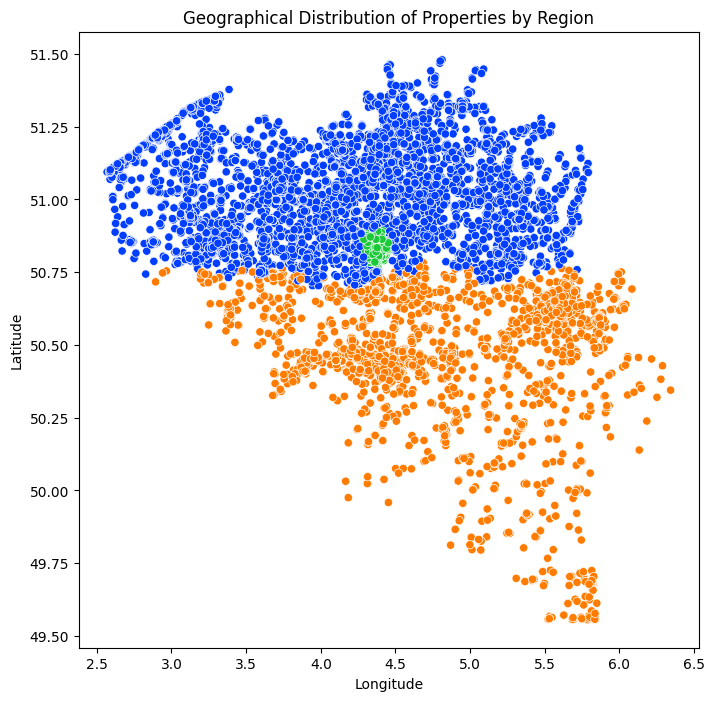

In [11]:
dropna_coord_df = df.dropna(subset=['latitude', 'longitude'])

plt.figure(figsize=(8, 8))
sns.scatterplot(x='longitude', y='latitude', hue='region', palette='bright', data=dropna_coord_df, legend=False)
plt.title('Geographical Distribution of Properties by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


We can observe a more dense concentration of points in the north which could be a reflection of a larger population density and also reveal a link between higher prices and real estate activity. This would need to be confirmed with additional data.

## Price Correlation

Now let's analyse the relationships between `price` and the other numerical variables to find the ones that are correlated.

We will use a heatmap to visualise the correlations.

In [12]:
list(df.select_dtypes(include='float'))


['price',
 'postalCode',
 'floor',
 'latitude',
 'longitude',
 'bedroomCount',
 'netHabitableSurface',
 'constructionYear',
 'facadeCount',
 'floorCount',
 'gardenSurface',
 'terraceSurface',
 'land',
 'bathroomCount',
 'toiletCount',
 'parkingCountIndoor',
 'primaryEnergyConsumptionPerSqm',
 'bookmarkCount',
 'viewCount']

In [13]:
heatmap_cols = ['price',
    'netHabitableSurface',
    'floor',
    'bedroomCount',
    'constructionYear',
    'facadeCount',
    'floorCount',
    'gardenSurface',
    'terraceSurface',
    'land',
    'latitude',
    'bathroomCount',
    'toiletCount',
    'parkingCountIndoor',
    'primaryEnergyConsumptionPerSqm',
    'viewCount']

In [14]:
correlation_matrix = df[heatmap_cols].corr().round(2)
correlation_matrix.sort_values(by='price', ascending=False).head()

,price,netHabitableSurface,floor,bedroomCount,constructionYear,facadeCount,floorCount,gardenSurface,terraceSurface,land,latitude,bathroomCount,toiletCount,parkingCountIndoor,primaryEnergyConsumptionPerSqm,viewCount
price,1.00,0.52,0.01,0.39,0.03,0.17,0.08,0.22,0.06,0.18,0.16,0.53,0.46,0.00,-0.02,-0.01
bathroomCount,0.53,0.44,-0.00,0.58,-0.08,0.09,0.03,0.10,0.04,0.08,-0.05,1.00,0.60,0.01,0.01,-0.00
netHabitableSurface,0.52,1.00,0.00,0.48,-0.16,0.22,-0.03,0.20,0.04,0.11,-0.06,0.44,0.52,-0.00,0.01,0.03
toiletCount,0.46,0.52,0.01,0.61,-0.13,0.16,-0.01,0.17,0.03,0.06,-0.09,0.60,1.00,0.00,0.00,0.04
bedroomCount,0.39,0.48,0.00,1.00,-0.18,0.23,-0.05,0.14,0.05,0.09,-0.11,0.58,0.61,0.00,0.03,0.09


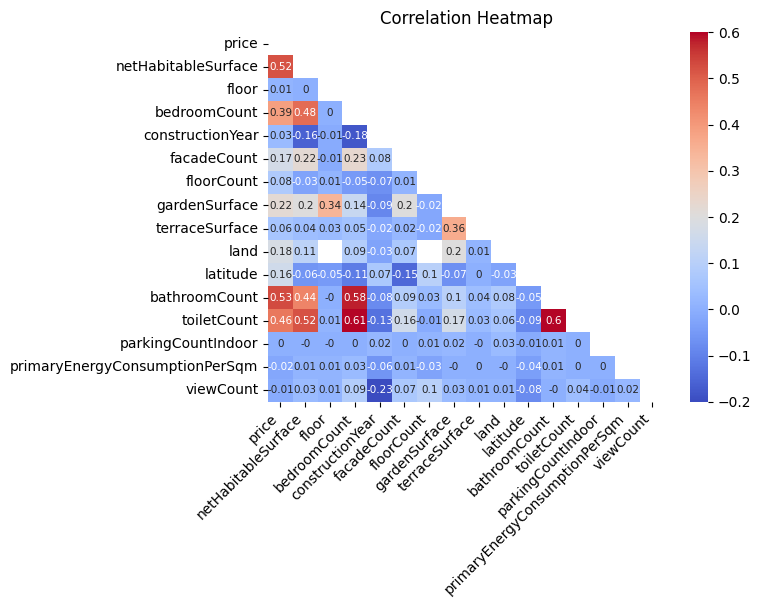

In [15]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

correlation_heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, annot_kws={"size":7.5},vmin=-0.2, vmax=0.6)
correlation_heatmap.set_xticklabels(correlation_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
correlation_heatmap.set(title='Correlation Heatmap')
plt.show()

This heatmap show us that, exculding `price` correlations, only home related parameters are correlated with each other (e.g. `toiletCount` vs `bathroomCount`)

Let's isolate this heatmap to only display `price` correlations.

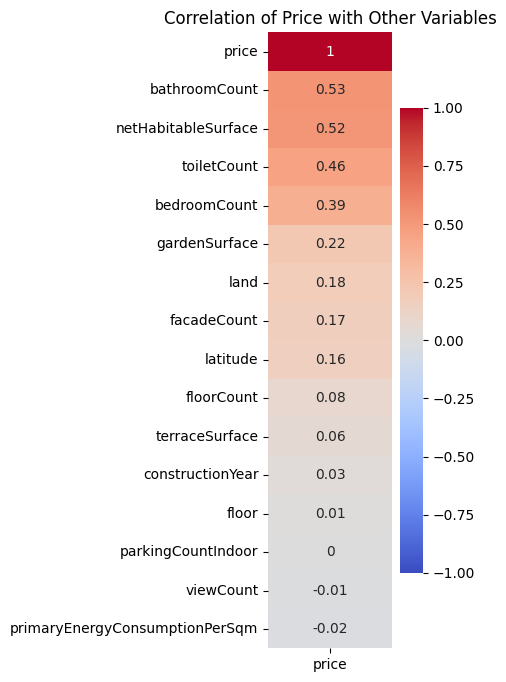

In [16]:
price_corr = correlation_matrix['price'].sort_values(ascending=False)

df_corr_price = pd.DataFrame(price_corr)

plt.figure(figsize=(2, 8))
sns.heatmap(df_corr_price, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation of Price with Other Variables')
plt.show()

This heatmap show us that `price` tend to increase with `bathroom count`, `habitable surface`, `toilet count` and `bedroom count` which is consistent with common expectations.